In [1]:
import pandas as pd
import sys
from keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from kornmo import KornmoDataset
from frostdataset import FrostDataset
from geodata import get_farmer_elevation
from visualize import plot
import kornmo_utils as ku
from visualize import plot_history


%load_ext autoreload
%autoreload 2

In [3]:
def filter_by_years(years, data):
    return data[data['year'].isin(years)]

def get_interpolated_data(years, weather_feature):
    data = pd.DataFrame()

    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/nn_interpolated/{weather_feature}/{weather_feature}_interpolated_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    # Drop columns containing 'Unnamed'
    data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year', 'longitude', 'latitude', 'elevation']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])

    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_proximity_data(years, weather_feature):
    data = pd.DataFrame()
    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/by_proximity/{weather_feature}/{weather_feature}_by_proximity_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.drop(columns=['ws_id'], inplace=True)
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])


    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

In [9]:
frost = FrostDataset()
kornmo = KornmoDataset()

years = [2017, 2018, 2019, 2020]

# Grants and deliveries
data = kornmo.get_deliveries().pipe(ku.split_farmers_on_type)
data = filter_by_years(years, data)
data
#45314 x 15
#60462 x 15

Loading deliveries...
Number of deliveries loaded: 88624


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,areal,bygg,havre,hvete,rug_og_rughvete
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,59.0,1.0,0.0,0.0,0.0
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,215.0,1.0,0.0,0.0,0.0
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,70.0,1.0,0.0,0.0,0.0
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,15.0,0.0,0.0,1.0,0.0
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,106.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60457,2020,999659209,3812,31,64,0,61.0,0.0,0.0,32209,61.0,0.0,0.0,0.0,1.0
60458,2020,999662730,3802,247,1,0,302.0,0.0,0.0,100087,217.0,0.0,1.0,0.0,0.0
60459,2020,999662730,3802,247,1,0,302.0,0.0,0.0,39067,80.0,0.0,0.0,1.0,0.0
60460,2020,999665462,3028,69,1,0,274.0,0.0,56512.0,38686,115.0,0.0,1.0,0.0,0.0


In [10]:
# Temperature and Precipitation
temp_and_precip_data = frost.get_as_aggregated(1, years=years)

Loading weather data...
Weather data entries loaded: 43157


In [11]:
data = data.merge(temp_and_precip_data, on=['year', 'orgnr'])
data = filter_by_years(years, data)
data
# 49044 x 1523
# 65277 x 1523

,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,total_rain204,total_rain205,total_rain206,total_rain207,total_rain208,total_rain209,total_rain210,total_rain211,total_rain212,total_rain213
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.82,0.47,0.03,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,2.76
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,...,0.43,-0.00,0.23,0.15,0.08,-0.00,0.71,0.04,-0.00,0.83
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,...,0.43,-0.00,0.23,0.15,0.08,-0.00,0.71,0.04,-0.00,0.83
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,...,0.06,-0.00,0.36,0.05,0.03,-0.00,-0.00,-0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59211,2020,999659209,3812,31,64,0,61.0,0.0,0.0,32209,...,-0.00,-0.00,0.07,1.11,1.01,3.53,0.00,-0.00,0.02,0.37
59212,2020,999662730,3802,247,1,0,302.0,0.0,0.0,100087,...,-0.00,-0.00,0.01,1.07,0.98,4.09,0.35,-0.00,0.23,0.56
59213,2020,999662730,3802,247,1,0,302.0,0.0,0.0,39067,...,-0.00,-0.00,0.01,1.07,0.98,4.09,0.35,-0.00,0.23,0.56
59214,2020,999665462,3028,69,1,0,274.0,0.0,56512.0,38686,...,-0.00,-0.00,0.07,0.90,1.02,2.86,0.05,-0.00,0.15,0.16


In [12]:
# lat, lon , elevation
elevation_data = get_farmer_elevation()
data = data.merge(elevation_data, on=['orgnr'])
data = filter_by_years(years, data)

In [13]:
# Legacy grants
historical_data = ku.get_historical_production(kornmo, data.year.unique(), 4)
data = data.merge(historical_data, on=['orgnr', 'year'])
data = filter_by_years(years, data)
data
# 47191 x 1541
# 62309 x 1541

Loading historical grants data...
Historical data loaded for years 2013 to 2020.


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,havre_sum_1,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,0.000,0.0,2.0620,0.0000,0.0,0.0,2.2445,0.0000,0.0,0.0
1,2018,811555762,5028,24,2,0,59.0,0.0,0.0,22259,...,0.000,0.0,2.2445,0.0000,0.0,0.0,1.7067,0.0000,0.0,0.0
2,2019,811555762,5028,24,2,0,59.0,0.0,0.0,23342,...,0.000,0.0,1.7067,0.0000,0.0,0.0,2.2259,0.0000,0.0,0.0
3,2020,811555762,5028,24,2,0,59.0,0.0,0.0,20520,...,0.000,0.0,2.2259,0.0000,0.0,0.0,2.3342,0.0000,0.0,0.0
4,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.000,0.0,6.4999,0.0000,0.0,0.0,11.7227,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57218,2020,999522955,5059,557,1,0,1099.0,5.0,452499.0,135505,...,0.000,0.0,0.0000,0.0000,0.0,0.0,15.4282,0.0000,0.0,0.0
57219,2020,999528090,3048,41,1,0,603.0,0.0,0.0,239208,...,0.000,0.0,0.0000,10.3534,0.0,0.0,0.0000,39.2479,0.0,0.0
57220,2020,999530982,3014,642,2,0,504.0,0.0,0.0,66977,...,0.000,0.0,3.3506,0.0000,0.0,0.0,10.0697,6.4118,0.0,0.0
57221,2020,999530982,3014,642,2,0,504.0,0.0,0.0,13442,...,0.000,0.0,3.3506,0.0000,0.0,0.0,10.0697,6.4118,0.0,0.0


In [14]:
data.dropna(inplace=True)

data['y'] = data['levert'] / data['areal']
data.drop('levert', axis=1, inplace=True)

data['y'] = ku.normalize(data['y'], 0, 1000)
data['areal'] = ku.normalize(data['areal'])
data['fulldyrket'] = ku.normalize(data['fulldyrket'])
data['overflatedyrket'] = ku.normalize(data['overflatedyrket'])
data['tilskudd_dyr'] = ku.normalize(data['tilskudd_dyr'])
data['growth_start_day'] = ku.normalize(data['growth_start_day'])
data['elevation'] = ku.normalize(data['elevation'])
data['lat'] = ku.normalize(data['lat'])

y_column = ['y']
remove_from_training = ['orgnr', 'kommunenr', 'gaardsnummer', 'bruksnummer', 'festenummer', 'year'] + y_column

data
# 41383 x 1541

,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,areal,...,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3,y
0,2017,811555762,1653,24,2,0,0.007241,0.00000,0.000000,0.017475,...,0.0,2.0620,0.0000,0.0,0.0,2.2445,0.0000,0.0,0.0,0.289271
1,2018,811555762,5028,24,2,0,0.007241,0.00000,0.000000,0.017475,...,0.0,2.2445,0.0000,0.0,0.0,1.7067,0.0000,0.0,0.0,0.377271
2,2019,811555762,5028,24,2,0,0.007241,0.00000,0.000000,0.017475,...,0.0,1.7067,0.0000,0.0,0.0,2.2259,0.0000,0.0,0.0,0.395627
3,2020,811555762,5028,24,2,0,0.007241,0.00000,0.000000,0.017475,...,0.0,2.2259,0.0000,0.0,0.0,2.3342,0.0000,0.0,0.0,0.347797
4,2017,811580082,1124,25,5,0,0.110575,0.00000,0.335581,0.064477,...,0.0,6.4999,0.0000,0.0,0.0,11.7227,0.0000,0.0,0.0,0.377693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57218,2020,999522955,5059,557,1,0,0.164127,0.01548,0.420247,0.096113,...,0.0,0.0000,0.0000,0.0,0.0,15.4282,0.0000,0.0,0.0,0.423453
57219,2020,999528090,3048,41,1,0,0.089305,0.00000,0.000000,0.144622,...,0.0,0.0000,10.3534,0.0,0.0,0.0000,39.2479,0.0,0.0,0.497314
57220,2020,999530982,3014,642,2,0,0.074370,0.00000,0.000000,0.078337,...,0.0,3.3506,0.0000,0.0,0.0,10.0697,6.4118,0.0,0.0,0.256617
57221,2020,999530982,3014,642,2,0,0.074370,0.00000,0.000000,0.018379,...,0.0,3.3506,0.0000,0.0,0.0,10.0697,6.4118,0.0,0.0,0.216806


In [15]:
train, val = train_test_split(shuffle(data), test_size=0.2)
val, test = train_test_split(val, test_size=0.2)

train_x = train.drop(remove_from_training, axis=1).to_numpy()
train_y = train[y_column].to_numpy()

val_x = val.drop(remove_from_training, axis=1).to_numpy()
val_y = val[y_column].to_numpy()

print(f'Training dataset x: {train_x.shape}')
print(f'Training dataset y: {train_y.shape}')
print(f'Validation dataset x: {val_x.shape}')
print(f'Validation dataset y : {val_y.shape}')


Training dataset x: (45704, 883)
Training dataset y: (45704, 1)
Validation dataset x: (9141, 883)
Validation dataset y : (9141, 1)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               226304    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 267,521
Trainable params: 267,521
Non-tr

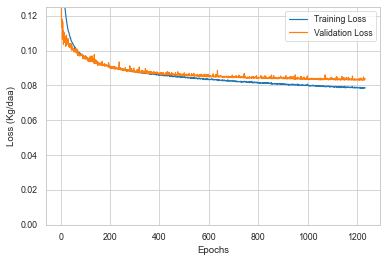

Denormalized MAE: 82.96861517551835


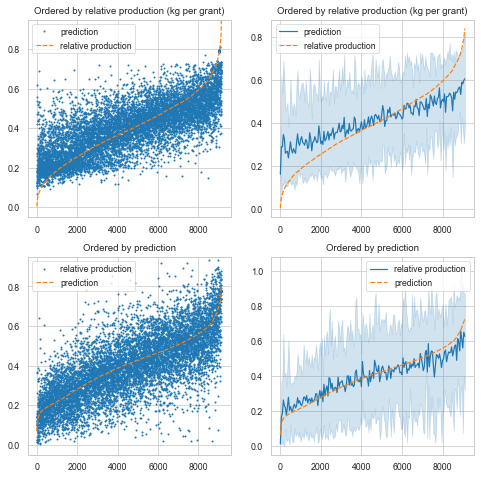

In [23]:
from dense_model import train_simple_dense
logs_name = 'more_data'

model, history = train_simple_dense(train_x, train_y, val_x, val_y)

plot(model, val_x, val_y)



# plot_history(history, save_file=f"logs/dnn_loss_{logs_name}.svg")
# print("Saving model and history object")
#
# pd.DataFrame(history.history).to_csv(f'logs/history_{logs_name}.csv')
# model.save(f"logs/dnn_model_{logs_name}.keras")

In [ ]:
history = pd.read_csv(f'logs/history_{logs_name}.csv')
plot_history(history, save_file=f"logs/dnn_loss_{logs_name}.svg")

model = load_model(f"logs/dnn_model_{logs_name}.keras")
plot(model, val_x, val_y)